# `obs_prerank_enrich()` Enrichment: Gene Interaction List with Rank Scores for Observations

### Step 1: Prepare `rank_df`

Begin by preparing a list of gene interactions along with their preranked scores. Store this information in a DataFrame called `rank_df`.

- The **index** of `rank_df` should be the gene interaction symbols. e.g. `A1CF_APOB	`
- The **columns** of `rank_df` should correspond to observation IDs (e.g., sample or cell identifier).

This format allows `obs_prerank_enrich()` to perform enrichment analysis using observation-level ranked interaction-level statistics.


In this tutorial, we use gene interaction data from the [GSE30550][GSE30550] dataset for H3N2-infected subjects sampling across time. 

For each sample, gene–gene interactions and their corresponding entropy-based Critical Transition (CT) scores were precomputed by [CRISGI][CRISGI] (`grea/data/GSE30550_H3N2_CRISGI_score.csv`).





In [32]:
%load_ext autoreload

import pandas as pd
rank_df = pd.read_csv("grea/data/GSE30550_H3N2_CRISGI_score.csv", index_col=0)
rank_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,s1 -24h,s1 0h,s1 5h,s1 12h,s1 21h,s1 29h,s1 36h,s1 45h,s1 53h,s1 60h,s1 69h,s1 77h,s1 84h,s1 93h,s1 101h,s1 108h
symbol,,,,,,,,,,,,,,,,
A1CF_APOB,3.380000e-07,5.360000e-07,1.400000e-07,3.580000e-07,4.370000e-07,0.000827,5.470000e-07,1.180000e-06,1.690000e-06,5.550000e-08,4.020000e-07,1.380000e-07,7.330000e-07,7.190000e-07,8.240000e-07,6.280000e-08
A2M_ALB,9.190000e-09,1.340000e-08,1.240000e-08,4.920000e-09,1.850000e-08,0.000256,2.620000e-08,3.010000e-09,1.200000e-09,3.910000e-08,5.990000e-10,1.130000e-08,6.510000e-09,2.170000e-08,9.850000e-10,1.410000e-08
A2M_AMBP,3.110000e-08,3.580000e-07,3.510000e-08,6.790000e-08,2.780000e-08,0.000291,3.100000e-07,6.050000e-08,1.020000e-07,1.080000e-07,3.350000e-08,1.470000e-08,8.880000e-09,3.730000e-08,4.060000e-09,2.910000e-09
A2M_APOA1,2.080000e-07,1.510000e-08,3.820000e-07,1.550000e-08,4.930000e-07,0.001086,5.000000e-07,1.870000e-07,7.920000e-08,6.450000e-08,9.930000e-08,2.760000e-08,1.480000e-07,2.140000e-08,4.700000e-08,2.800000e-07
A2M_APP,2.370000e-07,1.240000e-07,7.810000e-08,2.610000e-07,1.430000e-07,0.000393,4.270000e-07,1.020000e-07,2.600000e-07,5.460000e-08,1.790000e-09,1.070000e-08,2.170000e-08,6.810000e-09,1.040000e-07,2.370000e-07


### Step 2: Preparing Gene Set Libraries

There are several ways to prepare gene set libraries for use in GREA:

##### Option 1: Use Built-in Libraries
Simply specify the `libraries` you're interested in as a list. For example:

```python
libraries = ['KEGG_2021_Human']
```

You can use the `grea.library.list_libraries()` function to view all available pathway libraries included in GREA.

##### Option 2: Load from GMT File
You can load external gene set libraries from `.gmt` files using:

```python
libraries = read_gmt('your_library_file.gmt')
```

##### Option 3: Define a Custom Library
Create your own gene set library using a Python dictionary, where each key is a pathway name and the corresponding value is a list of genes:

```python
libraries = {
    'term1': ['A2M', 'APP'],
    'term2': ['A1CF', 'APOB']
}
```

In [4]:
from grea.library import list_libraries

print(list_libraries())

['GeneSigDB', 'Enrichr_Submissions_TF-Gene_Coocurrence', 'SysMyo_Muscle_Gene_Sets', 'WikiPathway_2021_Human', 'HomoloGene', 'WikiPathways_2013', 'PFOCR_Pathways_2023', 'OMIM_Disease', 'Data_Acquisition_Method_Most_Popular_Genes', 'NIBR_Jensen_DISEASES_Curated_2025', 'Cancer_Cell_Line_Encyclopedia', 'WikiPathways_2016', 'WikiPathways_2015', 'RNAseq_Automatic_GEO_Signatures_Human_Up', 'Human_Gene_Atlas', 'KOMP2_Mouse_Phenotypes_2022', 'MoTrPAC_2023', 'Kinase_Perturbations_from_GEO_down', 'Disease_Signatures_from_GEO_down_2014', 'Disease_Perturbations_from_GEO_up', 'Old_CMAP_down', 'MCF7_Perturbations_from_GEO_up', 'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'PPI_Hub_Proteins', 'Disease_Signatures_from_GEO_up_2014', 'GTEx_Tissue_Expression_Up', 'NIBR_DRUGseq_2025_down', 'L1000_Kinase_and_GPCR_Perturbations_up', 'ARCHS4_Cell-lines', 'VirusMINT', 'KEGG_2019_Human', 'ARCHS4_Tissues', 'MGI_Mammalian_Phenotype_Level_4', 'The_Kinase_Librar

### Step 3: Run Enrichment

To perform enrichment analysis, call the `grea.obs_prerank_enrich(rank_df, libraries)` function. The observation-level enrichment do not estimate the p-value for efficiency. You can customize the analysis using the following arguments:

- **`sig_sep`**: The delimiter used to separate gene names in an interaction string (e.g., set `sig_sep='_'` for interactions like `A2M_AMBP`).

The function returns a GREA object containing all enrichment results, including enrichment scores and statistical significance for each library term.



In [33]:
%autoreload

from grea import grea
libraries = ['KEGG_2021_Human']
sig_sep = '_'
obj = grea.obs_prerank_enrich(rank_df, libraries, sig_sep=sig_sep)
obj

---Finished: Load KEGG_2021_Human with 320 terms.


### Step 4: Check Enrichment Results

The `GREA` object stores all enrichment results, including enrichment scores and statistical significance for each library term. GREA supports three types of enrichment scores, each reflecting a different scoring strategy:

- `'KS-ES'`: Kolmogorov–Smirnov-based Enrichment Score, capturing the peak deviation between hit and miss distributions.
- `'KS-ESD'`: KS-based enrichment Score Difference, the sum of the maximum positive and negative deviations from the running score.
- `'RC-AUC'`: Area Under the Recovery Curve, summarizing early enrichment of target genes along the ranking.

You can select the appropriate metric depending on your analysis goal or data characteristics.

To retrieve the enrichment results as a long DataFrame, use the `get_enrich_results(metric)` function, as a wide DataFrame, use the `get_enrich_score(metric)`.

In [34]:
%autoreload

df = obj.get_enrich_results(metric='KS-ES')
df.head()

,Term,Obs,KS-ES,N_lead_sigs,Lead_sigs
190,KEGG_2021_Human|Oocyte meiosis,s1 108h,0.833789,199,CDC20_FBXO5;CCNB1_CDC20;CDC20_CENPM;BIRC5_CDC2...
189,KEGG_2021_Human|One carbon pool by folate,s1 108h,0.829352,32,BIRC5_TYMS;RRM2_TYMS;CCNB2_TYMS;DPYD_TYMS;CDC4...
109,"KEGG_2021_Human|Glycine, serine and threonine ...",s1 108h,0.828369,30,AHSP_ALAS2;BPGM_ENO2;ALAS2_GNMT;ALAS2_HBD;ALAS...
106,KEGG_2021_Human|Glutathione metabolism,s1 108h,0.828179,63,CCNB1_RRM2;CDC20_RRM2;BIRC5_RRM2;CENPM_RRM2;CD...
220,KEGG_2021_Human|Porphyrin and chlorophyll meta...,s1 108h,0.822830,26,AHSP_ALAS2;ALAS2_GNMT;ALAS2_HBD;ALAS2_HMBS;ALA...


In [35]:
%autoreload

df = obj.get_enrich_score(metric='KS-ES')
df.head()

,s1 -24h,s1 0h,s1 5h,s1 12h,s1 21h,s1 29h,s1 36h,s1 45h,s1 53h,s1 60h,s1 69h,s1 77h,s1 84h,s1 93h,s1 101h,s1 108h
KEGG_2021_Human|ABC transporters,0.534848,0.448287,0.249589,0.455413,0.287627,0.495515,0.256987,-0.162640,-0.301806,-0.272147,-0.229137,0.274393,-0.358780,-0.269382,-0.186018,-0.351217
KEGG_2021_Human|AGE-RAGE signaling pathway in diabetic complications,0.333807,0.225845,0.449939,0.289909,-0.198786,0.120718,0.868396,0.819802,0.823229,0.677201,0.290928,0.344129,0.196258,0.487515,0.454684,-0.197361
KEGG_2021_Human|AMPK signaling pathway,0.194808,0.274043,0.177802,0.140077,-0.205039,0.146201,-0.042705,-0.105274,-0.112521,-0.172765,0.219105,0.203368,0.203952,0.150618,0.191480,-0.268288
KEGG_2021_Human|Acute myeloid leukemia,0.146511,0.172203,0.284749,0.244221,-0.222500,-0.229949,0.319346,0.263699,0.261932,0.270608,0.326906,0.328356,0.287975,0.297143,0.168369,-0.154065
KEGG_2021_Human|Adherens junction,-0.140491,-0.233823,0.106506,-0.140749,-0.345522,-0.248893,0.128135,-0.100212,-0.279370,-0.289267,0.122337,0.345925,-0.217721,-0.160355,-0.351508,-0.331649


In [36]:
%autoreload

df = obj.get_enrich_results(metric='KS-ESD')
df.head()

,Term,Obs,KS-ESD,N_lead_sigs,Lead_sigs
190,KEGG_2021_Human|Oocyte meiosis,s1 108h,0.833656,199,CDC20_FBXO5;CCNB1_CDC20;CDC20_CENPM;BIRC5_CDC2...
109,"KEGG_2021_Human|Glycine, serine and threonine ...",s1 108h,0.828113,30,AHSP_ALAS2;BPGM_ENO2;ALAS2_GNMT;ALAS2_HBD;ALAS...
106,KEGG_2021_Human|Glutathione metabolism,s1 108h,0.827666,63,CCNB1_RRM2;CDC20_RRM2;BIRC5_RRM2;CENPM_RRM2;CD...
189,KEGG_2021_Human|One carbon pool by folate,s1 108h,0.827375,32,BIRC5_TYMS;RRM2_TYMS;CCNB2_TYMS;DPYD_TYMS;CDC4...
220,KEGG_2021_Human|Porphyrin and chlorophyll meta...,s1 108h,0.822575,26,AHSP_ALAS2;ALAS2_GNMT;ALAS2_HBD;ALAS2_HMBS;ALA...


In [37]:
%autoreload

df = obj.get_enrich_score(metric='KS-ESD')
df.head()

,s1 -24h,s1 0h,s1 5h,s1 12h,s1 21h,s1 29h,s1 36h,s1 45h,s1 53h,s1 60h,s1 69h,s1 77h,s1 84h,s1 93h,s1 101h,s1 108h
KEGG_2021_Human|ABC transporters,0.511203,0.407616,0.176826,0.376474,0.155942,0.463461,0.186559,-0.147816,-0.278010,-0.255795,-0.178515,0.175072,-0.341155,-0.252330,-0.016976,-0.325003
KEGG_2021_Human|AGE-RAGE signaling pathway in diabetic complications,0.329535,0.219237,0.448604,0.232311,-0.145386,0.054873,0.868396,0.819802,0.823229,0.676934,0.272957,0.330748,0.140979,0.484311,0.452682,-0.136341
KEGG_2021_Human|AMPK signaling pathway,0.189554,0.271545,0.167614,0.017506,-0.186566,0.055528,-0.000044,-0.034709,-0.045422,-0.105014,0.196263,0.180146,0.139460,0.086312,0.077620,-0.248719
KEGG_2021_Human|Acute myeloid leukemia,0.105796,0.107385,0.283232,0.194244,-0.205442,-0.186339,0.319082,0.263370,0.249745,0.269883,0.323344,0.303507,0.254921,0.294108,0.143894,-0.096854
KEGG_2021_Human|Adherens junction,-0.083482,-0.212193,0.053437,-0.093015,-0.327512,-0.187230,0.058383,-0.064658,-0.260653,-0.266837,0.055335,0.341037,-0.163204,-0.129680,-0.332212,-0.311838


In [38]:
%autoreload

df = obj.get_enrich_results(metric='RC-AUC')
df.head()

,Term,Obs,RC-AUC
109,"KEGG_2021_Human|Glycine, serine and threonine ...",s1 108h,0.953141
106,KEGG_2021_Human|Glutathione metabolism,s1 108h,0.943651
235,KEGG_2021_Human|Pyrimidine metabolism,s1 108h,0.933254
220,KEGG_2021_Human|Porphyrin and chlorophyll meta...,s1 108h,0.929520
189,KEGG_2021_Human|One carbon pool by folate,s1 108h,0.927640


In [39]:
%autoreload

df = obj.get_enrich_score(metric='RC-AUC')
df.head()

,s1 -24h,s1 0h,s1 5h,s1 12h,s1 21h,s1 29h,s1 36h,s1 45h,s1 53h,s1 60h,s1 69h,s1 77h,s1 84h,s1 93h,s1 101h,s1 108h
KEGG_2021_Human|ABC transporters,0.718711,0.665311,0.538542,0.615976,0.548046,0.627654,0.613326,0.439840,0.351713,0.378386,0.416161,0.544981,0.272527,0.349374,0.466111,0.306033
KEGG_2021_Human|AGE-RAGE signaling pathway in diabetic complications,0.645504,0.572198,0.702981,0.580559,0.413195,0.522266,0.954440,0.930258,0.926730,0.840799,0.592138,0.615884,0.535635,0.710733,0.688033,0.416877
KEGG_2021_Human|AMPK signaling pathway,0.561423,0.598393,0.576290,0.484662,0.403737,0.513076,0.505712,0.471960,0.460665,0.426655,0.552232,0.549321,0.530229,0.500018,0.484148,0.355587
KEGG_2021_Human|Acute myeloid leukemia,0.523083,0.512464,0.621245,0.567902,0.398017,0.432257,0.671118,0.620194,0.582949,0.590875,0.636876,0.613659,0.577460,0.620615,0.530357,0.440861
KEGG_2021_Human|Adherens junction,0.435979,0.371047,0.503430,0.452619,0.291266,0.408459,0.538561,0.470905,0.340907,0.357279,0.503653,0.639332,0.405177,0.413240,0.299706,0.282959


### Step 5: Visualize Enrichment Results

To visualize the enrichment results, use the `pl_running_sum(metric, term, obs_id)` function by specifying the desired metric, term, and observation ID.


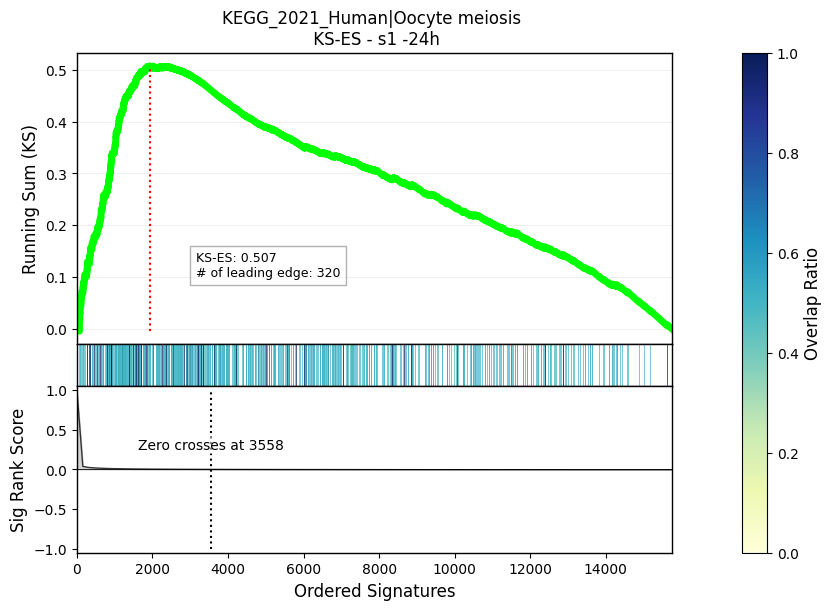

In [40]:
%autoreload
term = 'KEGG_2021_Human|Oocyte meiosis'
obs_id = 's1 -24h'
fig = obj.pl_running_sum('KS-ES', term, obs_id)
fig

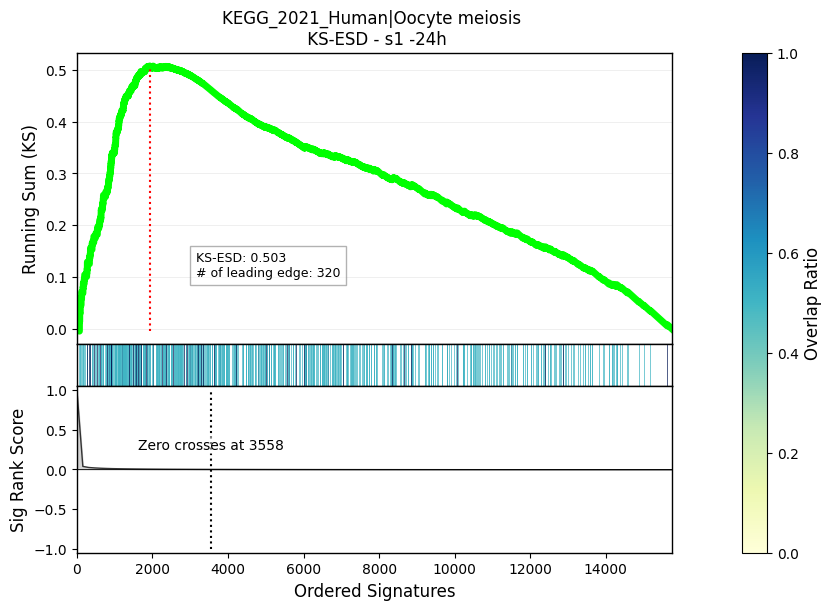

In [41]:
%autoreload
term = 'KEGG_2021_Human|Oocyte meiosis'
obs_id = 's1 -24h'
fig = obj.pl_running_sum('KS-ESD', term, obs_id)
fig

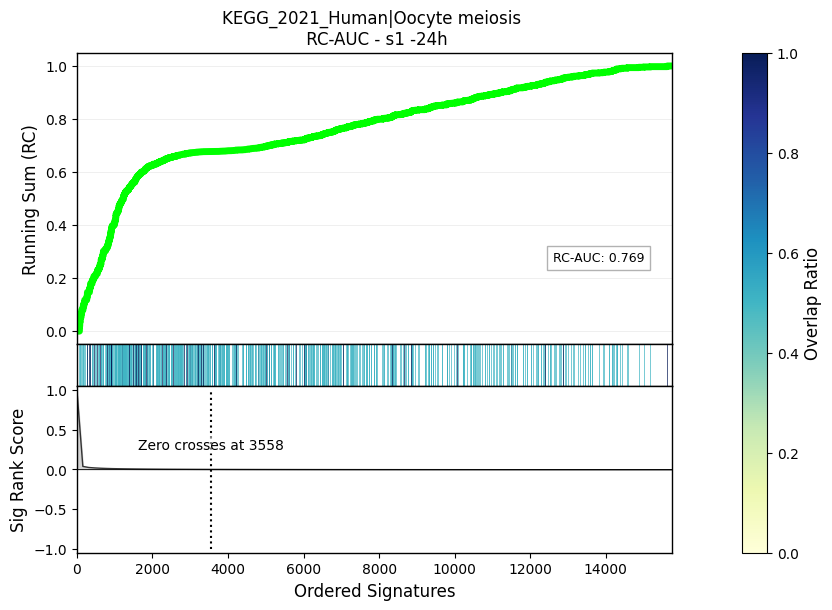

In [42]:
%autoreload
term = 'KEGG_2021_Human|Oocyte meiosis'
obs_id = 's1 -24h'
fig = obj.pl_running_sum('RC-AUC', term, obs_id)
fig